In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary librarie
import numpy as np
import matplotlib.pyplot as plt

C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implemen

In [2]:
geo_model = gp.create_model('Tutorial_ch1-1_Basics')

Advantage of sections: model resolution can be very low

In [3]:
# Importing the data from CSV-files and setting extent and resolution
gp.init_data(geo_model, [0,2000.,0,2000.,0,2000.],[5,5,5], 
      path_o = os.pardir+"/data/input_data/tut_chapter1/simple_fault_model_orientations.csv",
      path_i = os.pardir+"/data/input_data/tut_chapter1/simple_fault_model_points.csv", default_values=True); 

In [4]:
gp.map_series_to_surfaces(geo_model,
                            {"Fault_Series":'Main_Fault', 
                             "Strat_Series": ('Sandstone_2','Siltstone',
                                              'Shale', 'Sandstone_1', 'basement')}, remove_unused_series=True)

,surface,series,order_surfaces,isBasement,color,id
4,Main_Fault,Fault_Series,1,False,#443988,1
0,Shale,Strat_Series,1,False,#015482,2
1,Sandstone_1,Strat_Series,2,False,#9f0052,3
2,Siltstone,Strat_Series,3,False,#ffbe00,4
3,Sandstone_2,Strat_Series,4,False,#728f02,5
5,basement,Strat_Series,5,True,#ff3f20,6


### Add sections

pass section dictionary with startpoint, endpoint and resolution (xy and z)
Current limitations:
- p2 > p1, otherwhise section plot with topography raises error because of scipy.interpolate.RectBivariateSpline, idea: replace with interp2d of same package, problem: looks weird sometimes

In [5]:
section_dict = {'section1':([0,0],[2000,2000],[100,80]),
         'section2':([800,0],[800,2000],[150,100]),
         'section3':([0,200],[1500,500],[200,150])} #p1,p2,resolution

In [6]:
geo_model.grid.set_section_grid(section_dict)

,start,stop,resolution
section1,"[0, 0]","[2000, 2000]","[100, 80]"
section2,"[800, 0]","[800, 2000]","[150, 100]"
section3,"[0, 200]","[1500, 500]","[200, 150]"


In [7]:
geo_model.grid.grid_types

array(['regular', 'custom', 'topography', 'sections', 'gravity'],
      dtype='<U10')

In [8]:
from gempy.plot import vis2d_sections

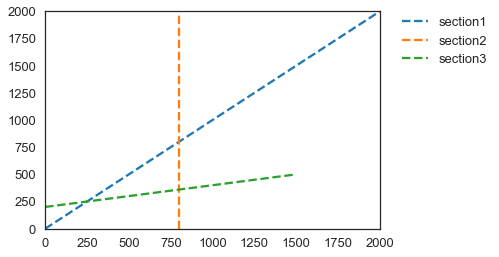

In [9]:
plot= vis2d_sections.PlotSolution(geo_model)
plot.plot_section_traces()

In [10]:
geo_model.set_is_fault(['Fault_Series'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,isFault,isFinite
Fault_Series,True,False
Strat_Series,False,False


In [11]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[])

Compiling theano function...
Compilation Done!


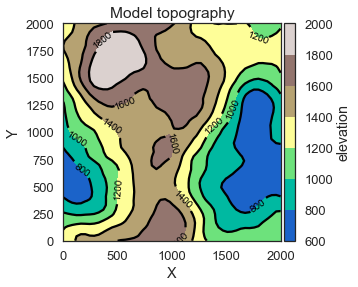

In [12]:
geo_model.set_topography(fd=1.2,d_z=np.array([600,2000]),resolution=np.array([50,50]))

In [13]:
sol = gp.compute_model(geo_model, compute_mesh=False)

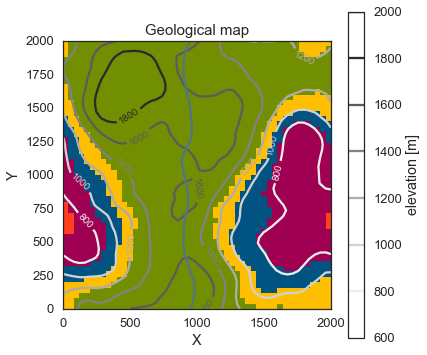

In [14]:
plot= vis2d_sections.PlotSolution(geo_model)
plot.plot_map(geo_model.solutions)

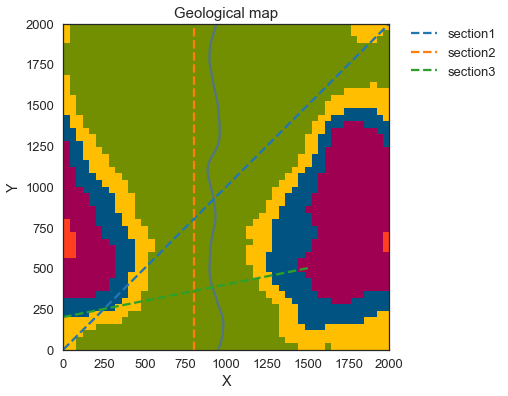

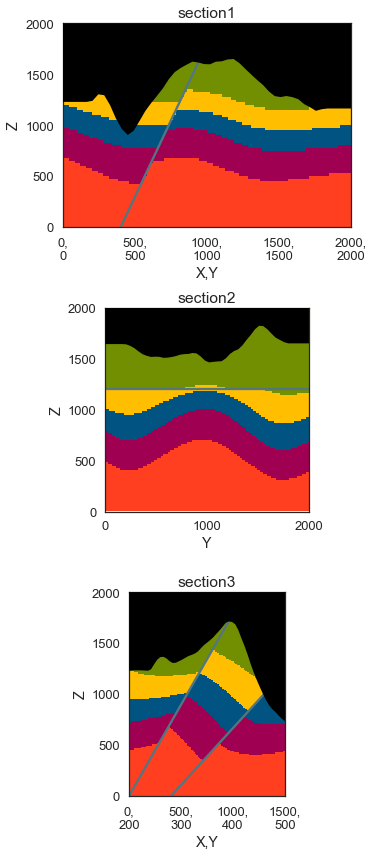

In [15]:
plot.plot_sections(show_traces=True)

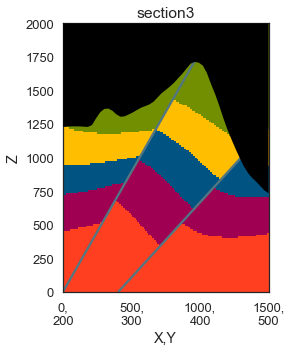

In [16]:
### This is wrong. There is only one fault?!?!
#I think it is due to how I generate the coordinates for diagonal sections
plot.plot_sections(figsize=(5,5), section_names = ['section3'],show_traces=False)